In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline
# Always make it pretty.
plt.style.use('ggplot')

In [91]:
# Load data from file
df = pd.read_csv('churn.csv')

In [92]:
# test whether it has been balanced 
print(df[df.target == 0.0].uid.count())
print(df[df.target == 1.0].uid.count())

199799
199799


## Build Random Forest Model

### 1. Define Features and Target

In [70]:
selected_features = df.columns.tolist()
selected_features.remove('target')
selected_features.remove('uid')
target = 'target'

In [71]:
X = df[selected_features].values
y = df['target'].values
print(X.shape)
print(y.shape)

(399598, 11)
(399598,)


### 2. Use cross validation to split the data into 5-fold cv

In [72]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle = True, random_state = 1129)
print(kf)

cv_feature = []
cv_traget = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    cv_feature.append([X_train, X_test])
    cv_traget.append([y_train, y_test])

KFold(n_splits=5, random_state=1129, shuffle=True)


### 3.Fit a Random Forest model using sklearn

In [73]:
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

# store the prediction result 
y_train_pred_list = []
y_test_pred_list = []
y_train_true_list = []
y_test_true_list = []

# Create a random forest Classifier. By convention, clf means 'Classifier'
model = RandomForestClassifier(max_depth = 30, n_estimators = 300, n_jobs=-1, random_state=1129)

# cv_feature shape: [[(1)],[(2)],[(3)],[(4)],[(5)]], (i) = X_train, X_test, i = 1,2,3,4,5.
# cv_traget shape: [[(1)],[(2)],[(3)],[(4)],[(5)]], (i) = y_train, y_test, i = 1,2,3,4,5.

for index in range(len(cv_feature)):
    
    # define the X_train, y_train, X_test, y_test
    X_train = cv_feature[index][0]
    y_train = cv_traget[index][0]
    X_test = cv_feature[index][1]
    y_test = cv_traget[index][1]
    
    # Fit a model by providing X and y from training set
    model.fit(X_train, y_train)

    # Make prediction on the training data
    y_train_pred = model.predict(X_train)

    # Make predictions on test data
    y_test_pred = model.predict(X_test)
    
    # store the result
    y_train_pred_list.append(y_train_pred)
    y_test_pred_list.append(y_test_pred)
    y_train_true_list.append(y_train)
    y_test_true_list.append(y_test)

### 4. Calculate the metric scores for the model

In [74]:
# Import metrics functions from sklearn
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

In [75]:
# Helper method to print metric scores
def print_results(y_true, y_pred):
    a, p, r, f = do_metric(y_true, y_pred)
    print("Accuracy of the Logistic Regression is: {}".format(a))
    print("Precision of the Logistic Regression is: {}".format(p))
    print("Recall of the Logistic Regression is: {}".format(r))
    print("f1-score of the Logistic Regression is: {}".format(f))

def do_metric(y_true, y_pred):
    a_list = []
    p_list = []
    r_list = []
    f_list = []
    for index in range(len(y_true)):
        a_list.append(accuracy_score(y_true[index], y_pred[index]))
        p_list.append(precision_score(y_true[index], y_pred[index]))
        r_list.append(recall_score(y_true[index], y_pred[index]))
        f_list.append(f1_score(y_true[index], y_pred[index]))
    return (np.mean(np.array(a_list)), np.mean(np.array(p_list)), np.mean(np.array(r_list)), np.mean(np.array(f_list)))

In [76]:
print("Training set scores:")
print_results(y_train_true_list, y_train_pred_list)

Training set scores:
Accuracy of the Logistic Regression is: 0.9939995945369711
Precision of the Logistic Regression is: 0.9893758563931268
Recall of the Logistic Regression is: 0.9987235652319326
f1-score of the Logistic Regression is: 0.9940277145042176


In [77]:
print("Test set scores:")
print_results(y_test_true_list, y_test_pred_list)

Test set scores:
Accuracy of the Logistic Regression is: 0.8450467742420532
Precision of the Logistic Regression is: 0.8469973177481688
Recall of the Logistic Regression is: 0.8422436603023176
f1-score of the Logistic Regression is: 0.8446120026311725


### 5. Estimated Coefficients

In [78]:
#View a list of the features and their importance scores
df_coeffs = pd.DataFrame(list(zip(selected_features, model.feature_importances_))).sort_values(by=[1], ascending=False)
df_coeffs.columns = ['feature', 'importance score']
df_coeffs

,feature,importance score
10,last 30 days play time percentage of song length,0.227786
9,last 14 days play time percentage of song length,0.188209
5,recency on play log,0.161377
3,last 14 days frequency on play log,0.123090
4,last 30 days frequency on play log,0.099360
8,last 7 days play time percentage of song length,0.069342
2,last 7 days frequency on play log,0.062374
7,last 3 days play time percentage of song length,0.033005
1,last 3 days frequency on play log,0.024713
6,last 1 days play time percentage of song length,0.007516


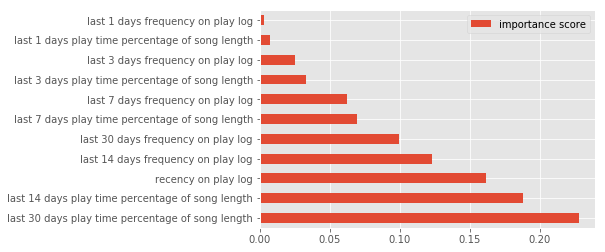

In [79]:
ax = df_coeffs.plot.barh()
t = np.arange(X.shape[1])
ax.set_yticks(t)
ax.set_yticklabels(df_coeffs['feature'])
plt.show()

### 6. More Model Evaluation

#### 6.1 Confusion Matrix

In [80]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

In [81]:
confusion_matrix(y_train_true_list[0], y_train_pred_list[0])

array([[158385,   1722],
       [   236, 159335]])

In [82]:
# Helper method to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    '''
    Code from sklearn example.
    '''
    
    cm = confusion_matrix(y_true, y_pred)

    print(cm)

    # Show confusion matrix in a separate window
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[158385   1722]
 [   236 159335]]


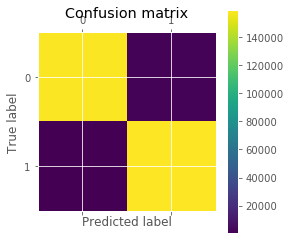

In [83]:
plot_confusion_matrix(y_train_true_list[0], y_train_pred_list[0])

[[33632  6060]
 [ 6472 33756]]


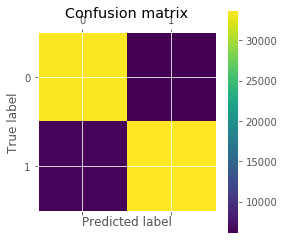

In [84]:
plot_confusion_matrix(y_test_true_list[0], y_test_pred_list[0])

#### 6.2 AUC

In [85]:
print("Area Under Curve (AUC) of the Logistic Regression is: {}".format(roc_auc_score(y_test_true_list[4], y_test_pred_list[4])))

Area Under Curve (AUC) of the Logistic Regression is: 0.8436349260329443


#### 6.3 Classification report

In [86]:
print(classification_report(y_test_true_list[0], y_test_pred_list[0]))

             precision    recall  f1-score   support

        0.0       0.84      0.85      0.84     39692
        1.0       0.85      0.84      0.84     40228

avg / total       0.84      0.84      0.84     79920



#### 6.4 Plot ROC curve

In [87]:
# Make predictions of the probability to be "positive"/"churn"/"1", as compared to "negative"/"not churn"/"0"
X_test = cv_feature[0][1]
y_test_pred_proba = model.predict_proba(X_test)[:,1]
y_test = y_test_true_list[0]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)

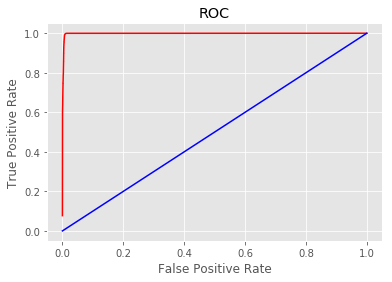

In [88]:
# plot TPR against FPR
plt.plot(fpr, tpr, color='red')

# plot 45 degree line
xx = np.linspace(0, 1.0, 20)
plt.plot(xx, xx, color='blue')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")

plt.show()

In [89]:
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=1129, verbose=0,
            warm_start=False)